Import thư viện

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage import measure, segmentation, morphology, feature
from scipy import ndimage
import pandas as pd
from scipy.spatial import distance
import glob
import warnings
from PIL import Image
import seaborn as sns
warnings.filterwarnings('ignore')
# Thiêt lập hiên thị hình anh
plt.rcParams['figure.figsize'] = (12, 8)
print("Các thư viện đã được import thành công!")

Các thư viện đã được import thành công!


Tiền xử lý và phân đoạn ảnh

In [12]:
def preprocess_image(image_path):
    # Đọc ảnh bằng PIL để hỗ trợ Unicode path
    try:
        pil_img = Image.open(image_path).convert('RGB')
        img = np.array(pil_img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    except Exception as e:
        raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {image_path}\n{e}")
    
    # Chuyển thành ảnh grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Làm mờ để giảm nhiễu
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return img, gray

def segment_bird(img, gray):
    # Áp dụng phép ngưỡng thích nghi
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)

    # Áp dụng phép toán hình thái để lọc nhiễu
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Xác định vùng chắc chắn là nền
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Tìm các contour
    contours, hierarchy = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Lấy contour có diện tích lớn nhất (giả định là chim)
    if len(contours) > 0:
        max_contour = max(contours, key=cv2.contourArea)
        
        # Tạo mặt nạ từ contour lớn nhất
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [max_contour], 0, 255, -1)
        
        # Áp dụng thêm phép toán hình thái để làm mịn mặt nạ
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        return mask, max_contour, hierarchy
    else:
        raise ValueError("Không tìm thấy contour trong ảnh")

def visualize_segmentation(img, mask, contour):
    # Tạo ảnh phân đoạn
    segmented = cv2.bitwise_and(img, img, mask=mask)
    
    # Vẽ đường viền
    contour_img = img.copy()
    cv2.drawContours(contour_img, [contour], 0, (255, 0, 0), 2)
    
    # Hiển thị các ảnh
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Ảnh gốc')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mặt nạ phân đoạn')
    axes[1].axis('off')
    
    axes[2].imshow(contour_img)
    axes[2].set_title('Đường viền phát hiện')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return segmented

Trích xuất đặc trưng tỷ lệ hình học (Geometric Ratios)

In [13]:
def extract_geometric_ratios(contour, mask):
    # Tính bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Tỷ lệ chiều dài thân so với chiều cao
    body_ratio = w / h
    
    # Tính toán các đặc điểm của đường viền
    # Tìm điểm xa nhất bên trái và bên phải
    leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
    rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
    topmost = tuple(contour[contour[:, :, 1].argmin()][0])
    bottommost = tuple(contour[contour[:, :, 1].argmax()][0])
    
    # Chiều dài toàn bộ
    total_length = rightmost[0] - leftmost[0]
    
    # Ước tính phần đầu (30% bên trái của chim)
    head_length = total_length * 0.3
    
    # Ước tính phần đuôi (25% bên phải của chim)
    tail_length = total_length * 0.25
    
    # Ước tính phần thân (phần còn lại)
    body_length = total_length - head_length - tail_length
    
    # Ước tính chiều dài mỏ (10% của tổng chiều dài)
    beak_length = total_length * 0.1
    
    # Tính các tỷ lệ
    beak_head_ratio = beak_length / head_length
    tail_body_ratio = tail_length / body_length
    
    # Tính aspect ratio của toàn bộ chim
    bird_aspect_ratio = total_length / (bottommost[1] - topmost[1])
    
    # Tính độ tròn (circularity)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
    
    # Tính độ lồi (convexity)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    convexity = area / hull_area if hull_area > 0 else 0
    
    # Kết quả là dictionary chứa các tỷ lệ hình học
    geometric_features = {
        'body_ratio': body_ratio,
        'beak_head_ratio': beak_head_ratio,
        'tail_body_ratio': tail_body_ratio,
        'bird_aspect_ratio': bird_aspect_ratio,
        'circularity': circularity,
        'convexity': convexity
    }
    
    return geometric_features

def visualize_geometric_features(img, contour, geometric_features):
    # Tạo bản sao của ảnh để vẽ lên
    result_img = img.copy()
    
    # Tính bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Vẽ bounding rectangle
    cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Tìm điểm xa nhất
    leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
    rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
    topmost = tuple(contour[contour[:, :, 1].argmin()][0])
    bottommost = tuple(contour[contour[:, :, 1].argmax()][0])
    
    # Vẽ điểm xa nhất
    cv2.circle(result_img, leftmost, 5, (255, 0, 0), -1)    # Blue for leftmost
    cv2.circle(result_img, rightmost, 5, (0, 0, 255), -1)   # Red for rightmost
    cv2.circle(result_img, topmost, 5, (255, 255, 0), -1)   # Cyan for topmost
    cv2.circle(result_img, bottommost, 5, (0, 255, 255), -1) # Yellow for bottommost
    
    # Tính chiều dài toàn bộ
    total_length = rightmost[0] - leftmost[0]
    
    # Ước tính phần đầu (30% bên trái của chim)
    head_right_x = leftmost[0] + int(total_length * 0.3)
    cv2.line(result_img, (head_right_x, y), (head_right_x, y+h), (255, 0, 255), 2)  # Magenta for head boundary
    
    # Ước tính phần đuôi (bắt đầu từ 75% chiều dài)
    tail_left_x = leftmost[0] + int(total_length * 0.75)
    cv2.line(result_img, (tail_left_x, y), (tail_left_x, y+h), (0, 255, 0), 2)  # Green for tail boundary
    
    # Ước tính phần mỏ (10% chiều dài từ leftmost)
    beak_right_x = leftmost[0] + int(total_length * 0.1)
    cv2.line(result_img, (beak_right_x, y), (beak_right_x, y+h), (255, 128, 0), 2)  # Orange for beak
    
    # Hiển thị ảnh với các đánh dấu
    plt.figure(figsize=(12, 10))
    plt.imshow(result_img)
    plt.title('Phân tích hình học của chim')
    plt.axis('off')
    
    # Hiển thị các tỷ lệ đã tính toán
    feature_text = f"""
    Tỷ lệ hình học:
    - Tỷ lệ thân (w/h): {geometric_features['body_ratio']:.3f}
    - Tỷ lệ mỏ/đầu: {geometric_features['beak_head_ratio']:.3f}
    - Tỷ lệ đuôi/thân: {geometric_features['tail_body_ratio']:.3f}
    - Tỷ lệ khung (l/h): {geometric_features['bird_aspect_ratio']:.3f}
    - Độ tròn: {geometric_features['circularity']:.3f}
    - Độ lồi: {geometric_features['convexity']:.3f}
    """
    
    plt.figtext(0.15, 0.02, feature_text, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

Trích xuất đặc trưng mô-men Hu (Hu Moments)

In [14]:
def extract_hu_moments(mask):
    # Tính các moments
    moments = cv2.moments(mask)
    
    # Tính 7 mô-men Hu
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Áp dụng logarithm để giảm khoảng giá trị (thường dùng cho phân lớp)
    # sign(hu) * log(abs(hu))
    log_hu = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    
    return hu_moments, log_hu

def visualize_hu_moments(log_hu):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, 8), log_hu)
    plt.title('Giá trị logarithm của 7 mô-men Hu')
    plt.xlabel('Chỉ số mô-men Hu')
    plt.ylabel('Log10 của giá trị tuyệt đối (dấu giữ nguyên)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, 8))
    
    # Hiển thị giá trị cụ thể
    for i, v in enumerate(log_hu):
        plt.text(i + 1, v + 0.1, f"{v:.3f}", ha='center')
        
    plt.tight_layout()
    plt.show()
    
    # In ra giá trị chi tiết
    print("Chi tiết 7 mô-men Hu:")
    for i, (h, log_h) in enumerate(zip(hu_moments, log_hu)):
        print(f"Hu[{i+1}] = {h:.8e} (log: {log_h:.4f})")

Trích xuất đặc trưng đường viền Fourier (Fourier Descriptors)

In [15]:
def extract_fourier_descriptors(contour, n_descriptors=20):
    # Đảm bảo contour là một mảng numpy
    contour = np.squeeze(contour)
    
    # Kiểm tra xem contour có đủ điểm không
    if contour.shape[0] < n_descriptors:
        raise ValueError(f"Contour có quá ít điểm ({contour.shape[0]}) cho {n_descriptors} mô tả")
    
    # Chuyển đổi tọa độ contour thành số phức
    complex_contour = contour[:, 0] + 1j * contour[:, 1]
    
    # Tính biến đổi Fourier
    fourier_result = np.fft.fft(complex_contour)
    
    # Lấy n_descriptors mô tả đầu tiên (loại bỏ DC component)
    fourier_descriptors = fourier_result[1:n_descriptors+1]
    
    # Chuẩn hóa để bất biến với tỷ lệ, quay và dịch chuyển
    fd_normalized = np.abs(fourier_descriptors) / np.abs(fourier_descriptors[0]) if np.abs(fourier_descriptors[0]) > 0 else np.abs(fourier_descriptors)
    
    return fd_normalized

def visualize_fourier_descriptors(fd_normalized):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(fd_normalized)+1), fd_normalized, 'o-')
    plt.title('Mô tả đường viền Fourier đã chuẩn hóa')
    plt.xlabel('Chỉ số mô tả Fourier')
    plt.ylabel('Biên độ đã chuẩn hóa')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(1, len(fd_normalized)+1, 2))
    
    # Hiển thị một số giá trị quan trọng
    for i in range(0, min(5, len(fd_normalized))):
        plt.text(i+1, fd_normalized[i] + 0.02, f"{fd_normalized[i]:.3f}", ha='center')
        
    plt.tight_layout()
    plt.show()
    
    # In ra các giá trị chi tiết
    print("Chi tiết các mô tả đường viền Fourier:")
    for i, fd in enumerate(fd_normalized):
        print(f"FD[{i+1}] = {fd:.6f}")
        if i >= 9:  # Chỉ hiển thị 10 giá trị đầu tiên
            print("...")
            break

Tích hợp và trích xuất tất cả đặc trưng

In [16]:
def extract_all_shape_features(image_path, visualize=True):
    # Tiền xử lý ảnh
    img, gray = preprocess_image(image_path)
    
    # Phân đoạn chim
    try:
        mask, contour, hierarchy = segment_bird(img, gray)
    except ValueError as e:
        print(f"Lỗi khi phân đoạn ảnh: {e}")
        return None
    
    # Hiển thị kết quả phân đoạn
    if visualize:
        segmented = visualize_segmentation(img, mask, contour)
    
    # Trích xuất đặc trưng tỷ lệ hình học
    geometric_features = extract_geometric_ratios(contour, mask)
    
    # Trích xuất đặc trưng mô-men Hu
    hu_moments, log_hu = extract_hu_moments(mask)
    
    # Trích xuất đặc trưng đường viền Fourier
    try:
        fourier_descriptors = extract_fourier_descriptors(contour)
    except ValueError as e:
        print(f"Lỗi khi tính đặc trưng đường viền Fourier: {e}")
        fourier_descriptors = np.zeros(20)  # Giá trị mặc định nếu lỗi
    
    # Hiển thị các đặc trưng nếu yêu cầu
    if visualize:
        visualize_geometric_features(img, contour, geometric_features)
        visualize_hu_moments(log_hu)
        visualize_fourier_descriptors(fourier_descriptors)
    
    # Tạo dictionary chứa tất cả các đặc trưng
    all_features = {
        'geometric_features': geometric_features,
        'hu_moments': hu_moments.tolist(),
        'log_hu_moments': log_hu.tolist(),
        'fourier_descriptors': fourier_descriptors.tolist()
    }
    
    return all_features

Trích xuất đặc trưng từ toàn bộ tập dữ liệu

In [17]:
def extract_features_from_dataset(dataset_folder, patterns=["*.jpg", "*.jpeg"], max_images=None):
    # Tìm tất cả các file ảnh trong thư mục với nhiều pattern
    image_files = []
    for pattern in patterns:
        image_files.extend(glob.glob(os.path.join(dataset_folder, pattern)))
    
    # Loại bỏ trùng lặp nếu có
    image_files = list(set(image_files))
    
    # Giới hạn số lượng ảnh nếu cần
    if max_images is not None:
        image_files = image_files[:max_images]
    
    print(f"Tìm thấy {len(image_files)} ảnh để xử lý.")
    
    # Danh sách lưu trữ kết quả
    all_features = []
    
    # Xử lý từng ảnh
    for idx, img_path in enumerate(image_files):
        print(f"Đang xử lý ảnh {idx+1}/{len(image_files)}: {os.path.basename(img_path)}")
        
        # Trích xuất đặc trưng (không hiển thị hình ảnh)
        features = extract_all_shape_features(img_path, visualize=False)
        
        if features is not None:
            # Thêm tên file vào kết quả
            features['file_name'] = os.path.basename(img_path)
            all_features.append(features)
        else:
            print(f"  Bỏ qua ảnh do lỗi trích xuất đặc trưng.")
    
    # Tạo DataFrame chứa các đặc trưng
    if not all_features:
        return None
    
    # Tạo DataFrame cho đặc trưng hình học (có cấu trúc đơn giản)
    geometric_df = pd.DataFrame([{'file_name': f['file_name'], **f['geometric_features']} for f in all_features])
    
    # Tạo DataFrame cho mô-men Hu
    hu_df = pd.DataFrame([{'file_name': f['file_name'], 
                         **{f'hu_{i+1}': v for i, v in enumerate(f['hu_moments'])},
                         **{f'log_hu_{i+1}': v for i, v in enumerate(f['log_hu_moments'])}
                        } for f in all_features])
    
    # Tạo DataFrame cho đặc trưng Fourier
    fd_df = pd.DataFrame([{'file_name': f['file_name'], 
                         **{f'fd_{i+1}': v for i, v in enumerate(f['fourier_descriptors'])}} 
                        for f in all_features])
    
    # Kết hợp tất cả các DataFrame
    features_df = geometric_df.merge(hu_df, on='file_name').merge(fd_df, on='file_name')
    
    print(f"Đã trích xuất đặc trưng từ {len(features_df)} ảnh thành công.")
    print(f"Tổng số đặc trưng: {features_df.shape[1] - 1} (không tính tên file)")
    
    return features_df

Lưu trữ đặc trưng và phân tích ban đầu

In [18]:
def save_features(features_df, output_file="bird_shape_features.csv"):
    features_df.to_csv(output_file, index=False)
    print(f"Đã lưu đặc trưng vào file: {output_file}")

def analyze_features(features_df):
    # Thống kê mô tả
    print("Thống kê các đặc trưng hình học:")
    print(features_df[[col for col in features_df.columns 
                  if col in ['body_ratio', 'beak_head_ratio', 'tail_body_ratio',
                             'bird_aspect_ratio', 'circularity', 'convexity']]].describe())
    
    # Phân tích tương quan
    print("\nMa trận tương quan giữa các đặc trưng hình học:")
    corr = features_df[[col for col in features_df.columns 
                if col in ['body_ratio', 'beak_head_ratio', 'tail_body_ratio',
                           'bird_aspect_ratio', 'circularity', 'convexity']]].corr()
    print(corr)
    
    # Vẽ ma trận tương quan
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Ma trận tương quan giữa các đặc trưng hình học')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Trích xuất đặc trưng từ tập dữ liệu trong thư mục: ../../data
Tìm thấy 202 ảnh để xử lý.
Đang xử lý ảnh 1/202: istockphoto-1135506483-612x612.jpg
Đang xử lý ảnh 2/202: premium_photo-1675714692342-01dfd2e6b6b5.jpg
Đang xử lý ảnh 3/202: free-photo-of-dong-phoebe.jpeg
Đang xử lý ảnh 4/202: sri-lanka-whiteeye-bird-perched-600nw-2132414103.jpg
Đang xử lý ảnh 5/202: pexels-photo-3832408.jpeg
Đang xử lý ảnh 6/202: pexels-photo-2769633.jpeg
Đang xử lý ảnh 7/202: istockphoto-1732009136-640x640.jpg
Đang xử lý ảnh 8/202: pexels-robert-schwarz-1488822070-31895264.jpg
Đang xử lý ảnh 9/202: photo-1706245438313-f1af6bf94f84.jpg
Đang xử lý ảnh 10/202: istockphoto-2181795206-612x612.jpg
Đang xử lý ảnh 11/202: gettyimages-953005346-612x612.jpg
Đang xử lý ảnh 12/202: gettyimages-968383308-612x612.jpg
Đang xử lý ảnh 13/202: gettyimages-1536440902-612x612.jpg
Đang xử lý ảnh 14/202: pexels-photo-2827104.jpeg
Đang xử lý ảnh 15/202: bird-9362267_640.jpg
Đang xử lý ảnh 16/202: istockphoto-1132039168-612x612.jp

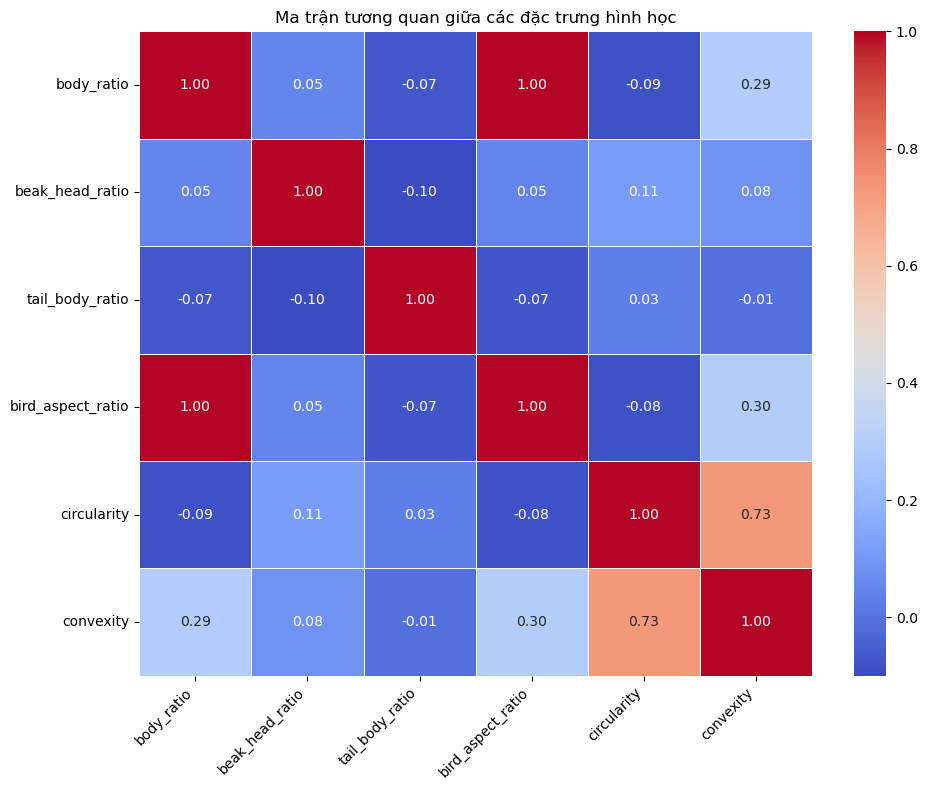

Đã lưu đặc trưng vào file: bird_shape_features.csv


In [24]:
def example_full_dataset(dataset_folder):
    print(f"Trích xuất đặc trưng từ tập dữ liệu trong thư mục: {dataset_folder}")
    
    # Trích xuất đặc trưng từ toàn bộ ảnh trong thư mục
    features_df = extract_features_from_dataset(dataset_folder)
    
    if features_df is not None:
        # Hiển thị kết quả
        print("\nXem trước 5 hàng đầu tiên của DataFrame kết quả:")
        print(features_df.head())
        
        # Phân tích đặc trưng
        analyze_features(features_df)
        
        # Lưu đặc trưng
        save_features(features_df, "bird_shape_features.csv")

# Gọi hàm với đường dẫn thư mục chứa ảnh
example_full_dataset("../../data")